# Face Recognition

Many of the ideas presented here are from [FaceNet](https://arxiv.org/pdf/1503.03832.pdf).

Face recognition problems commonly fall into one of two categories: 

**Face Verification** "Is this the claimed person?" For example, at some airports, you can pass through customs by letting a system scan your passport and then verifying that you (the person carrying the passport) are the correct person. A mobile phone that unlocks using your face is also using face verification. This is a 1:1 matching problem.

**Face Recognition** "Who is this person?"  This is a 1:K matching problem.

FaceNet learns a neural network that encodes a face image into a vector of 128 numbers. By comparing two such vectors, you can then determine if two pictures are of the same person.

In [1]:
#!pip install tensorflow
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
#!pip install scipy
# !pip install opencv-python
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
K.set_image_data_format('channels_last')

import numpy as np
import tensorflow as tf
import os
from numpy import genfromtxt
import pandas as pd
import PIL

%matplotlib inline


## Naive Face Verification

In Face Verification, you're given two images and you have to determine if they are of the same person. The simplest way to do this is to compare the two images pixel-by-pixel. If the distance between the raw images is below a chosen threshold, it may be the same person!

<img src="images/pixel_comparison.png" style="width:380px;height:150px;">
<caption><center> <u> <font color='purple'> <b>Figure 1</b> </u></center></caption>

Of course, this algorithm performs poorly, since the pixel values change dramatically due to variations in lighting, orientation of the person's face, minor changes in head position, and so on.

You'll see that rather than using the raw image, you can learn an encoding, $f(img)$.

By using an encoding for each image, an element-wise comparison produces a more accurate judgement as to whether two pictures are of the same person.


##  Encoding Face Images into a 128-Dimensional Vector -  Using a ConvNet to Compute Encodings

The FaceNet model takes a lot of data and a long time to train. So following the common practice in applied deep learning, we'll load weights that someone else has already trained.  An Inception network implementation is used here, and you can find it in the file `inception_blocks_v2.py` to get a closer look at how it is implemented.  

The key things to be aware of are:

- This network uses 160x160 dimensional RGB images as its input. Specifically, a face image (or batch of $m$ face images) as a tensor of shape $(m, n_H, n_W, n_C) = (m, 160, 160, 3)$
- The input images are originally of shape 96x96, thus, you need to scale them to 160x160. This is done in the `img_to_encoding()` function.
- The output is a matrix of shape $(m, 128)$ that encodes each input face image into a 128-dimensional vector

Run the cell below to create the model for face images!

In [2]:

#!pip install keras-facenet
from keras_facenet import FaceNet

embedder = FaceNet()  # This downloads the model automatically on first run (~92 MB)
model = embedder.model   # ← now 'model' is your familiar Keras model
print("Model loaded successfully!")

Model loaded successfully!


In [3]:
print(model.inputs)
print(model.outputs)

#512 actually used in this notebook instead of 128 due to model update

[<KerasTensor shape=(None, None, None, 3), dtype=float32, sparse=False, ragged=False, name=keras_tensor>]
[<KerasTensor shape=(None, 512), dtype=float32, sparse=False, ragged=False, name=keras_tensor_449>]




<img src="images/distance_kiank.png" style="width:680px;height:250px;">
<caption><center> <u> <font color='purple'> <b>Figure 2:</b> <br> </u> <font color='purple'>By computing the distance between two encodings and thresholding, you can determine if the two pictures represent the same person</center></caption>

So, an encoding is a good one if:

- The encodings of two images of the same person are quite similar to each other.
- The encodings of two images of different persons are very different.

The triplet loss function formalizes this, and tries to "push" the encodings of two images of the same person (Anchor and Positive) closer together, while "pulling" the encodings of two images of different persons (Anchor, Negative) further apart.
    
<img src="images/triplet_comparison.png" style="width:280px;height:150px;"><br>
<caption><center> <u> <font color='purple'> <b>Figure 3: </b> <br> </u> <font color='purple'> In the next section,  you'll call the pictures from left to right: Anchor (A), Positive (P), Negative (N)</center></caption>


### The Triplet Loss
The triplet loss is the main ingredient of the face recognition algorithm, and you'll need to know how to use it for training your own FaceNet model, as well as other types of image similarity problems. 

For an image $x$, its encoding is denoted as $f(x)$, where $f$ is the function computed by the neural network.

<img src="images/f_x.png" style="width:380px;height:150px;">

Training will use triplets of images $(A, P, N)$:

- A is an "Anchor" image--a picture of a person.
- P is a "Positive" image--a picture of the same person as the Anchor image.
- N is a "Negative" image--a picture of a different person than the Anchor image.

These triplets are picked from the training dataset. $(A^{(i)}, P^{(i)}, N^{(i)})$ is used here to denote the $i$-th training example.

You'd like to make sure that an image $A^{(i)}$ of an individual is closer to the Positive $P^{(i)}$ than to the Negative image $N^{(i)}$) by at least a margin $\alpha$:

$$
|| f\left(A^{(i)}\right)-f\left(P^{(i)}\right)||_{2}^{2}+\alpha<|| f\left(A^{(i)}\right)-f\left(N^{(i)}\right)||_{2}^{2}
$$


You would thus like to minimize the following "triplet cost":

$$\mathcal{J} = \sum^{m}_{i=1} \large[ \small \underbrace{\mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2}_\text{(1)} - \underbrace{\mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2}_\text{(2)} + \alpha \large ] \small_+ \tag{3}$$
Here, the notation "$[z]_+$" is used to denote $max(z,0)$.

**Notes**:

- The term (1) is the squared distance between the anchor "A" and the positive "P" for a given triplet; you want this to be small.
- The term (2) is the squared distance between the anchor "A" and the negative "N" for a given triplet, you want this to be relatively large. It has a minus sign preceding it because minimizing the negative of the term is the same as maximizing that term.
- $\alpha$ is called the margin. It's a hyperparameter that you pick manually. You'll use $\alpha = 0.2$.

In [4]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss as defined by formula (3)
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images
            positive -- the encodings for the positive images
            negative -- the encodings for the negative images
    
    Returns:
    loss -- real number, value of the loss
    """
    
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    

    # Step 1: Compute the (encoding) distance between the anchor and the positive
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis=-1)
    
    # Step 2: Compute the (encoding) distance between the anchor and the negative
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis=-1)
    
    # Step 3: subtract the two previous distances and add alpha.
    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)
    
    # Step 4: Take the maximum of basic_loss and 0.0. Sum over the training examples.
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0.0))
    
    
    
    return loss

In [7]:
tf.random.set_seed(1)
y_true = (None, None, None) # It is not used
y_pred = (tf.keras.backend.random_normal([3, 128], mean=6, stddev=0.1, seed = 1),
          tf.keras.backend.random_normal([3, 128], mean=1, stddev=1, seed = 1),
          tf.keras.backend.random_normal([3, 128], mean=3, stddev=4, seed = 1))
loss = triplet_loss(y_true, y_pred)
print("loss = " + str(loss))

loss = tf.Tensor(527.2596, shape=(), dtype=float32)


##  Loading the Pre-trained Model

FaceNet is trained by minimizing the triplet loss. But since training requires a lot of data and a lot of computation, you won't train it from scratch here. Instead, you'll load a previously trained model in the following cell; which might take a couple of minutes to run.

Here are some examples of distances between the encodings between three individuals:

<img src="images/distance_matrix.png" style="width:380px;height:200px;"><br>
<caption><center> <u> <font color='purple'> <b>Figure 4:</b></u> <br>  <font color='purple'> Example of distance outputs between three individuals' encodings</center></caption>

Now use this model to perform face verification and face recognition!


## Applying the Model

You're building a system for an office building where the building manager would like to offer facial recognition to allow the employees to enter the building.

You'd like to build a face verification system that gives access to a list of people. To be admitted, each person has to swipe an identification card at the entrance. The face recognition system then verifies that they are who they claim to be.


### Face Verification

Now you'll build a database containing one encoding vector for each person who is allowed to enter the office. To generate the encoding, you'll use `img_to_encoding(image_path, model)`, which runs the forward propagation of the model on the specified image.

Run the following code to build the database (represented as a Python dictionary). This database maps each person's name to a 128-dimensional encoding of their face.

In [8]:
FRmodel = model

In [9]:
#tf.keras.backend.set_image_data_format('channels_last')
def img_to_encoding(image_path, model):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(160, 160))
    img = np.around(np.array(img) / 255.0, decimals=12) #Normalize
    x_train = np.expand_dims(img, axis=0)
    embedding = model.predict_on_batch(x_train)
    return embedding / np.linalg.norm(embedding, ord=2)

In [10]:
database = {}
database["danielle"] = img_to_encoding("images/danielle.png", FRmodel)
database["younes"] = img_to_encoding("images/younes.jpg", FRmodel)
database["tian"] = img_to_encoding("images/tian.jpg", FRmodel)
database["andrew"] = img_to_encoding("images/andrew.jpg", FRmodel)
database["kian"] = img_to_encoding("images/kian.jpg", FRmodel)
database["dan"] = img_to_encoding("images/dan.jpg", FRmodel)
database["sebastiano"] = img_to_encoding("images/sebastiano.jpg", FRmodel)
database["bertrand"] = img_to_encoding("images/bertrand.jpg", FRmodel)
database["kevin"] = img_to_encoding("images/kevin.jpg", FRmodel)
database["felix"] = img_to_encoding("images/felix.jpg", FRmodel)
database["benoit"] = img_to_encoding("images/benoit.jpg", FRmodel)
database["arnaud"] = img_to_encoding("images/arnaud.jpg", FRmodel)

In [13]:
#Load the images of Danielle and Kian:
danielle = tf.keras.preprocessing.image.load_img("images/danielle.png", target_size=(160, 160))
kian = tf.keras.preprocessing.image.load_img("images/kian.jpg", target_size=(160, 160))

In [14]:
np.around(np.array(kian) / 255.0, decimals=12).shape

(160, 160, 3)

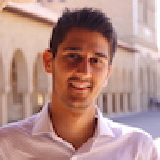

In [15]:
kian

In [16]:
np.around(np.array(danielle) / 255.0, decimals=12).shape

(160, 160, 3)

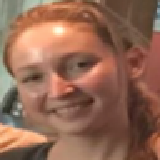

In [17]:
danielle

Now, when someone shows up at your front door and swipes their ID card (thus giving you their name), you can look up their encoding in the database, and use it to check if the person standing at the front door matches the name on the ID.

In [21]:
def verify(image_path, identity, database, model):
    """
    Function that verifies if the person on the "image_path" image is "identity".
    
    Arguments:
        image_path -- path to an image
        identity -- string, name of the person you'd like to verify the identity. Has to be an employee who works in the office.
        database -- python dictionary mapping names of allowed people's names (strings) to their encodings (vectors).
        model -- your Inception model instance in Keras
    
    Returns:
        dist -- distance between the image_path and the image of "identity" in the database.
        door_open -- True, if the door should open. False otherwise.
    """

    # Step 1: Compute the encoding for the image. Use img_to_encoding() see function above
    encoding = img_to_encoding(image_path, model)
    
    # Step 2: Compute distance with identity's image (≈ 1 line)
    dist = np.linalg.norm(encoding - database[identity])
    
    # Step 3: Open the door if dist < 0.7, else don't open (≈ 3 lines)
    if dist < 0.7:
        print("It's " + str(identity) + ", welcome in!")
        door_open = True
    else:
        print("It's not " + str(identity) + ", please go away")
        door_open = False
   
        
    return dist, door_open

Younes is trying to enter the office and the camera takes a picture of him ("images/camera_0.jpg"). Let's run your verification algorithm on this picture:

<img src="images/camera_0.jpg" style="width:100px;height:100px;">

In [22]:
distance, door_open_flag = verify("images/camera_0.jpg", "younes", database, FRmodel)
print("(", distance, ",", door_open_flag, ")")

It's younes, welcome in!
( 0.54487705 , True )


Benoit, who does not work in the office, stole Kian's ID card and tried to enter the office. Naughty Benoit! The camera took a picture of Benoit ("images/camera_2.jpg). 

<img src="images/camera_2.jpg" style="width:100px;height:100px;">

Run the verification algorithm to check if Benoit can enter.

In [23]:
verify("images/camera_2.jpg", "kian", database, FRmodel)

It's not kian, please go away


(np.float32(1.3556261), False)

###  Face Recognition

Our face verification system is mostly working. But since Kian got his ID card stolen, when he came back to the office the next day he couldn't get in!

To solve this, you'd like to change your face verification system to a face recognition system. This way, no one has to carry an ID card anymore. An authorized person can just walk up to the building, and the door will unlock for them!

You'll implement a face recognition system that takes as input an image, and figures out if it is one of the authorized persons (and if so, who). Unlike the previous face verification system, you will no longer get a person's name as one of the inputs.


In [24]:
def who_is_it(image_path, database, model):
    """
    Implements face recognition for the office by finding who is the person on the image_path image.
    
    Arguments:
        image_path -- path to an image
        database -- database containing image encodings along with the name of the person on the image
        model -- your Inception model instance in Keras
    
    Returns:
        min_dist -- the minimum distance between image_path encoding and the encodings from the database
        identity -- string, the name prediction for the person on image_path
    """

    ## Step 1: Compute the target "encoding" for the image. Use img_to_encoding() see example above. ## (≈ 1 line)
    encoding = img_to_encoding(image_path, model)
   
    ## Step 2: Find the closest encoding ##
   
    # Initialize "min_dist" to a large value, say 100 (≈1 line)
    min_dist = 100
   
    # Loop over the database dictionary's names and encodings.
    for (name, db_enc) in database.items():
       
        # Compute L2 distance between the target "encoding" and the current db_enc from the database. (≈ 1 line)
        dist = np.linalg.norm(encoding - db_enc)
        
        # If this distance is less than the min_dist, then set min_dist to dist, and identity to name. (≈ 3 lines)
        if dist < min_dist:
            min_dist = dist
            identity = name
    
    
    if min_dist > 0.7:
        print("Not in the database.")
    else:
        print ("it's " + str(identity) + ", the distance is " + str(min_dist))
        
    return min_dist, identity

Younes is at the front door and the camera takes a picture of him ("images/camera_0.jpg"). Let's see if our `who_it_is()` algorithm identifies Younes.

In [25]:
who_is_it("images/camera_0.jpg", database, FRmodel)

it's younes, the distance is 0.54487705


(np.float32(0.54487705), 'younes')

**Congratulations**! 
Our face recognition system is working well! It not only lets in authorized persons, but now people don't need to carry an ID card around anymore!


    
**What you should remember**:

- Face verification solves an easier 1:1 matching problem; face recognition addresses a harder 1:K matching problem.
    
- Triplet loss is an effective loss function for training a neural network to learn an encoding of a face image.

- The same encoding can be used for verification and recognition. Measuring distances between two images' encodings allows you to determine whether they are pictures of the same person.



**Ways to improve this facial recognition model**:

Here are some ways to further improve the algorithm:

- Put more images of each person (under different lighting conditions, taken on different days, etc.) into the database. Then, given a new image, compare the new face to multiple pictures of the person. This would increase accuracy.

- Crop the images to contain just the face, and less of the "border" region around the face. This preprocessing removes some of the irrelevant pixels around the face, and also makes the algorithm more robust.